In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gripql
conn = gripql.Connection("https://bmeg.io/api", credential_file="/tmp/bmeg_credentials.json")
O = conn.graph("bmeg_rc1_2")

Get Ensembl Gene ids for genes of interest

In [2]:
GENES = ["PTEN", "TP53", "RB1"]
gene_ids = {}
for g in GENES:
    for i in O.query().V().hasLabel("Gene").has(gripql.eq("symbol", g)):
        gene_ids[g] = i.gid

[INFO]	2019-03-11 15:50:32,116	1 results received in 0 seconds
[INFO]	2019-03-11 15:50:32,355	1 results received in 0 seconds
[INFO]	2019-03-11 15:50:32,599	1 results received in 0 seconds


In [3]:
gene_ids

{'PTEN': 'ENSG00000171862',
 'TP53': 'ENSG00000141510',
 'RB1': 'ENSG00000139687'}

For each gene of interest, obtain the copy number alteration values and aggregate them by gene.

In [7]:
q = O.query().V("Project:TCGA-PRAD").in_("InProject").in_("SampleFor").in_("AliquotFor")
q = q.has(gripql.eq("$.gdc_attributes.sample_type", 'Primary Tumor')).in_("CopyNumberAlterationOf")
q = q.aggregate(
    list( gripql.term( g, "values.%s" % (g), 5) for g in gene_ids.values() )
)

res = list(q)
for r in res[0]:
    for b in res[0][r]['buckets']:
        print("%s\t%s:%s" % (r, b['key'], b['value']))

[INFO]	2019-03-11 16:22:24,556	1 results received in 5 seconds


ENSG00000139687	0:269
ENSG00000139687	-1:139
ENSG00000139687	-2:81
ENSG00000139687	1:3
ENSG00000141510	0:329
ENSG00000141510	-1:126
ENSG00000141510	-2:37
ENSG00000171862	0:327
ENSG00000171862	-2:95
ENSG00000171862	-1:64
ENSG00000171862	1:5
ENSG00000171862	2:1


Create a barchart showing the counts of copy number altered samples in the cohort.

<BarContainer object of 4 artists>

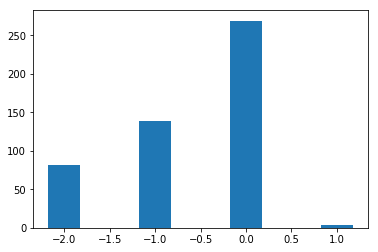

In [8]:
val = []
count = []
for i in sorted(res[0]['ENSG00000139687']['buckets'], key=lambda x:int(x["key"])):
    val.append(int(i["key"]))
    count.append(i["value"])
plt.bar(val, count, width=0.35)